In [1]:
!pip install catboost
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.0 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/SW_AI/'

In [5]:
drop_list = ['country','index']
train  = pd.read_csv(path +'./Data/train.csv')
test  = pd.read_csv(path + './Data/test.csv')


tipi_list = [f'TIPI{i + 1}' for i in range(10)]
drop_list = ['country','index']

for i in range(len(tipi_list) // 2):
    if i % 2 == 0:
        po_ti=tipi_list[i]
        ne_ti=tipi_list[i + 5]

    elif i % 2 == 1:
        po_ti=tipi_list[i + 5]
        ne_ti=tipi_list[i]

    train[ne_ti]=train[ne_ti].apply(lambda x : 6-x)
    train[f'gen_TIPI{i + 1}']=(train[po_ti]+train[ne_ti])/2
    test[ne_ti]=test[ne_ti].apply(lambda x : 6-x)
    test[f'gen_TIPI{i + 1}']=(test[po_ti]+test[ne_ti])/2

# VCL scoring
vcl_list = [f'VCL{i + 1}' for i in range(16)]

train_vcl_score_temp = train[vcl_list[0]]
test_vcl_score_temp = test[vcl_list[0]]
for i in vcl_list[1:]:
    if i == 'VCL6' or i == 'VCL9' or i == 'VCL12':
        train_vcl_score_temp -= train[i] * 4
        test_vcl_score_temp -= test[i] * 4
    else:
        train_vcl_score_temp += train[i]
        test_vcl_score_temp += test[i]

train['VCL_score'] = train_vcl_score_temp
test['VCL_score'] = test_vcl_score_temp

1.tipi 삭제

In [35]:
train['QID'] = ''
test['QID'] = ''
Q_list=[]
for i in range(1,27):
  train['QID'] += train[f'Q{i}'].astype(str)
  train['QID'] += '_'
  test['QID'] += test[f'Q{i}'].astype(str)
  test['QID'] += '_'
  Q_list.append(f'Q{i}')

personal_info=['education','urban', 'gender', 'engnat', 'age', 'hand', 'religion', 'orientation',
       'voted', 'married', 'familysize', 'ASD']
train['ID']=''
test['ID']=''
for i in personal_info:
  train['ID'] += train[i].astype(str)
  train['ID'] += '_'
  test['ID'] += test[i].astype(str)
  test['ID'] += '_'

train = train.drop(train[train.familysize > 50].index)
train = train.drop(train[train.age > 120].index)
train_y = train['nerdiness']
train_x = train.drop(drop_list + tipi_list + ['nerdiness'] + vcl_list, axis=1)
test = test.drop(drop_list + tipi_list + vcl_list, axis=1)
train_x.reset_index(drop=True,inplace=True)

2.tipi 삭제 x

In [87]:
train['QID'] = ''
test['QID'] = ''
Q_list=[]
for i in range(1,27):
  train['QID'] += train[f'Q{i}'].astype(str)
  train['QID'] += '_'
  test['QID'] += test[f'Q{i}'].astype(str)
  test['QID'] += '_'
  Q_list.append(f'Q{i}')

personal_info=['education','urban', 'gender', 'engnat', 'age', 'hand', 'religion', 'orientation',
       'voted', 'married', 'familysize', 'ASD']
train['ID']=''
test['ID']=''
for i in personal_info:
  train['ID'] += train[i].astype(str)
  train['ID'] += '_'
  test['ID'] += test[i].astype(str)
  test['ID'] += '_'

train = train.drop(train[train.familysize > 50].index)
train = train.drop(train[train.age > 120].index)
train_y = train['nerdiness']
train_x = train.drop(drop_list   + ['nerdiness'] + vcl_list, axis=1)
test = test.drop(drop_list   + vcl_list, axis=1)
train_x.reset_index(drop=True,inplace=True)

3. tipi 삭제, standard

In [6]:
train['QID'] = ''
test['QID'] = ''
Q_list=[]
for i in range(1,27):
  train['QID'] += train[f'Q{i}'].astype(str)
  train['QID'] += '_'
  test['QID'] += test[f'Q{i}'].astype(str)
  test['QID'] += '_'
  Q_list.append(f'Q{i}')

personal_info=['education','urban', 'gender', 'engnat', 'age', 'hand', 'religion', 'orientation',
       'voted', 'married', 'familysize', 'ASD']
train['ID']=''
test['ID']=''
for i in personal_info:
  train['ID'] += train[i].astype(str)
  train['ID'] += '_'
  test['ID'] += test[i].astype(str)
  test['ID'] += '_'

train = train.drop(train[train.familysize > 50].index)
train = train.drop(train[train.age > 120].index)
train_y = train['nerdiness']
train_x = train.drop(drop_list+ tipi_list + ['nerdiness'] + vcl_list, axis=1)
test = test.drop(drop_list + tipi_list  + vcl_list, axis=1)
train_x.reset_index(drop=True,inplace=True)

In [8]:
personal_info_cate=Q_list+['education','urban', 'gender', 'engnat', 'hand', 'religion', 'orientation','voted', 'married','ASD']
cus_categorical_list=personal_info_cate
for i in cus_categorical_list:
  train_x[i]=train_x[i].astype(object)
  test[i]=test[i].astype(object)

In [9]:
categorical_feats = train_x.dtypes[train_x.dtypes == "object"].index.tolist()
print("Number of categorical features: ", len(categorical_feats))

Number of categorical features:  38


In [10]:
numerical_feats = train_x.dtypes[train_x.dtypes != "object"].index.tolist()
print("Number of numerical features: ", len(numerical_feats))

Number of numerical features:  11


In [11]:
encoder = OrdinalEncoder(categorical_feats)
train_x[categorical_feats] = encoder.fit_transform(train_x[categorical_feats])
test[categorical_feats] = encoder.transform(test[categorical_feats])

In [12]:
train_x['ID'] = train_x['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')
train_x['QID'] = train_x['QID'].astype('int64')
test['QID'] = test['QID'].astype('int64')

In [13]:
categorical_feats

['Q1',
 'Q2',
 'Q3',
 'Q4',
 'Q5',
 'Q6',
 'Q7',
 'Q8',
 'Q9',
 'Q10',
 'Q11',
 'Q12',
 'Q13',
 'Q14',
 'Q15',
 'Q16',
 'Q17',
 'Q18',
 'Q19',
 'Q20',
 'Q21',
 'Q22',
 'Q23',
 'Q24',
 'Q25',
 'Q26',
 'education',
 'urban',
 'gender',
 'engnat',
 'hand',
 'religion',
 'orientation',
 'voted',
 'married',
 'ASD',
 'QID',
 'ID']

In [14]:
numerical_feats

['introelapse',
 'testelapse',
 'surveyelapse',
 'age',
 'familysize',
 'gen_TIPI1',
 'gen_TIPI2',
 'gen_TIPI3',
 'gen_TIPI4',
 'gen_TIPI5',
 'VCL_score']

In [15]:
scaler = StandardScaler()
cus_numerical_feats=['introelapse','testelapse','surveyelapse','age','familysize']
train_x[cus_numerical_feats] = scaler.fit_transform(train_x[cus_numerical_feats])
test[cus_numerical_feats] = scaler.transform(test[cus_numerical_feats])

In [16]:
n_est = 2000
seed = 7942
n_fold = 15
n_class = 2
train_x.reset_index(drop=True,inplace=True)

X = train_x
y = train_y
X_test = test

In [17]:
skfold = StratifiedKFold(n_splits=15, shuffle=True, random_state=2000)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = categorical_feats
for fold in range(15):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid= X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier()
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / 15
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------------- Fold 0 -----------------

Learning rate set to 0.060806
0:	learn: 0.6787642	test: 0.6774822	best: 0.6774822 (0)	total: 183ms	remaining: 3m 3s
100:	learn: 0.4524666	test: 0.3832954	best: 0.3832552 (99)	total: 11.2s	remaining: 1m 39s
200:	learn: 0.4333059	test: 0.3755993	best: 0.3755123 (189)	total: 27.9s	remaining: 1m 50s
300:	learn: 0.4178693	test: 0.3734733	best: 0.3733514 (278)	total: 38.6s	remaining: 1m 29s
400:	learn: 0.4040835	test: 0.3732668	best: 0.3730962 (367)	total: 49.1s	remaining: 1m 13s
500:	learn: 0.3915433	test: 0.3723560	best: 0.3722532 (495)	total: 59.5s	remaining: 59.2s
600:	learn: 0.3760620	test: 0.3718158	best: 0.3718158 (600)	total: 1m 10s	remaining: 46.8s
700:	learn: 0.3638293	test: 0.3721245	best: 0.3718158 (600)	total: 1m 21s	remaining: 34.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3718157644
bestIteration = 600

Shrink model to first 601 iterations.
CV Log Loss Score: 0.371816

----------------- Fold 1 -----------

In [24]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

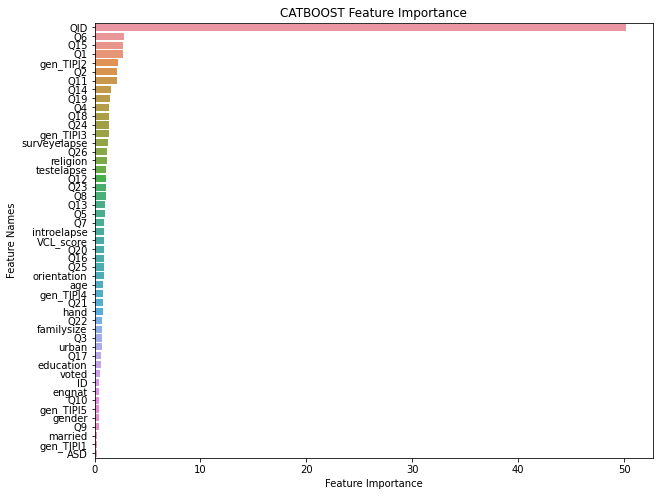

In [25]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [26]:
df=pd.DataFrame()
df['nerd']=0
for i in range(len(cat_pred_test)):
  if cat_pred_test[i][0]>=cat_pred_test[i][1]:
    df.loc[i]=0
  else:
    df.loc[i]=1

In [31]:
df2.value_counts()

nerd
1       20881
0       14571
dtype: int64

In [28]:
df1=pd.DataFrame()
df1['nerd']=0
for i in range(len(cat_pred_test)):
  if cat_pred_test[i][0]>=cat_pred_test[i][1]:
    df1.loc[i]=0
  else:
    df1.loc[i]=1

In [29]:
df1.value_counts()

nerd
1       20881
0       14571
dtype: int64

In [30]:
df1

,nerd
0,0
1,1
2,1
3,1
4,1
...,...
35447,1
35448,1
35449,1
35450,0


In [32]:
submission=pd.read_csv(path+'Data/sample_submission.csv')

In [33]:
submission

,index,nerdiness
0,0,-1
1,1,-1
2,2,-1
3,3,-1
4,4,-1
...,...,...
35447,35447,-1
35448,35448,-1
35449,35449,-1
35450,35450,-1


In [34]:
submission["nerdiness"] = df1['nerd']

In [35]:
submission.to_csv("08_11_2stcatboost.csv", index = False)